In [48]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf

tf.random.set_seed(1)
sns.set_style('darkgrid')

data_file = './data/model_ready.parquet'
df = pd.read_parquet(data_file, "pyarrow")

# sort index
df = df.sort_index()
# the frequency of the datatime index is not set. based on inspection, it is sampled hourly. here i will set the frequency to 1 hour in case in the future i may need to resample the data.
df = df.asfreq('H')

# separte names for inspection
columns = df.columns
load_names = []
wind_names = []
dewpoint_names = []
target_names = []
for col in columns:
    if 'mtlf' in col:
        load_names.append(col)
    if 'ws' in col:
        wind_names.append(col)
    if 'td' in col:
        dewpoint_names.append(col)
    if 'da_energy' in col:
        target_names.append(col)


## Features

As analyzed before, we will add the following features to dataset:
1. detrend target as previously we have shown the target is non stationary
1. time features: sine and cosine pairs of day, bimonth and year
2. add lags of (1,2,5,9) of the targets to the dataset


In [49]:
# add time features
date_time = df.index
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# the data has obvious daily pattern, bimonth pattern and annual pattern
day = 24*60*60
bimonth = (365.2425/6)*day
year = (365.2425)*day

# use cos/sin as 0 should be close to 23
df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['bimonth_sin'] = np.sin(timestamp_s * (2 * np.pi / bimonth))
df['bimonth_cos'] = np.cos(timestamp_s * (2 * np.pi / bimonth))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))



In [50]:
# let's play around with some target transformation
# we set to one target for now
target = target_names[0]
df_cpy = df.copy()

y = df_cpy[target]
df_cpy = df_cpy.drop(columns=target_names)
df_cpy = pd.concat([df_cpy, y], axis=1)

# add log target to reduce the long tail distribution of target
log_y = np.log(y + 50)
log_y.rename('log_'+target, inplace=True)
df_cpy = pd.concat([df_cpy, log_y], axis=1)

# add diff of target to remove trend
diff_y = y.diff()
df_cpy['diff_'+target] = diff_y

# add log diff of target to remove trend
logdiff_y = log_y.diff()
df_cpy['logdiff_'+target] = logdiff_y

## Split Data

In [51]:
# split train and test
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

n = len(df_cpy)
train_df = df_cpy[0:int(n*train_ratio)]
val_df = df_cpy[int(n*train_ratio):int(n*(train_ratio+val_ratio))]
test_df = df_cpy[int(n*(train_ratio+val_ratio)):]



## Normalize data

In [52]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

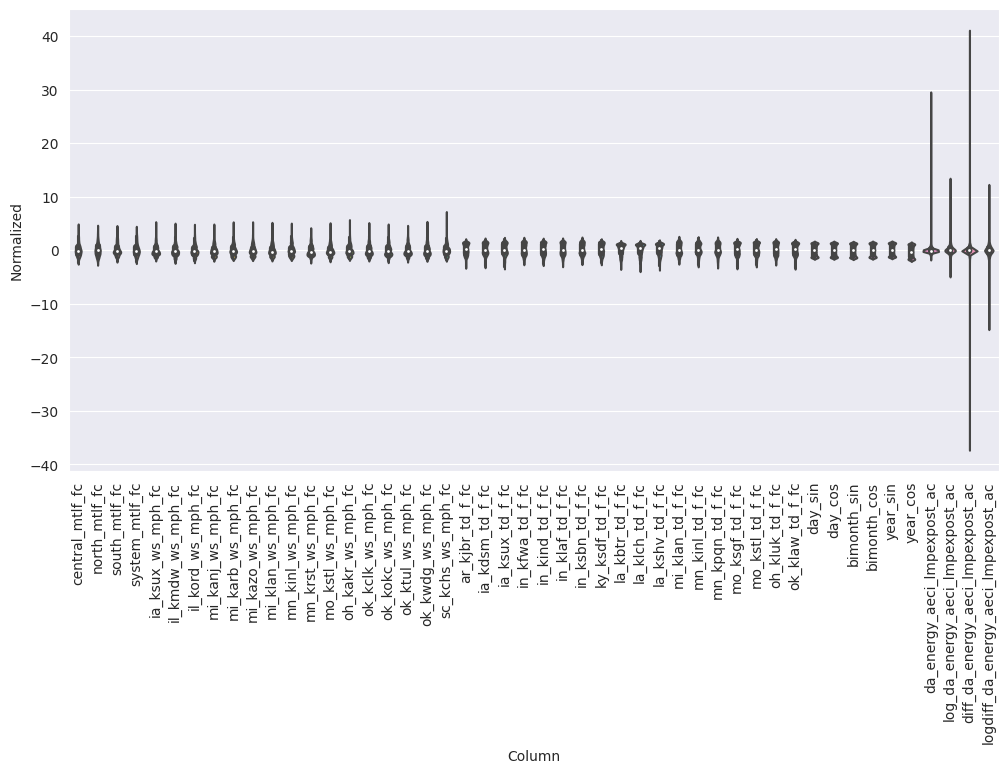

In [53]:
df_std = (df_cpy - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_cpy.keys(), rotation=90)


we notice that:
- the original target value has very long tail. 
- after removing the differece trend, the target value is now well centered around 0. but with long tails on both sides
- after log transformation, the long tail of the orignal target variable has been reduced, but still skewed to the right
- after log transformation of the difference trend removed target variable, the distribution is now well centered around 0, and the skewness is also reduced.

## Final Manipulation of Data

From the above experiment, we have a well centered target variable by applying first-order difference and log transformation. We will use this as our target variable.

In [54]:
def target_transform(y):
    return np.log(y+50).diff()

def inverse_target_transform(dy, y_start):
    return np.exp(dy.cumsum()+np.log(y_start+50)) - 50
    
# run a test for the above transform and inverse transform
# trasform
y = df[target]
y_start = y.iloc[0]
dy = target_transform(y)

# de-transform
y_recover = inverse_target_transform(dy, y_start)
y_recover.iloc[0] = y_start


In [55]:
# transform target with given function
y = df[target]
df = df.drop(columns=target_names)

y_start = y.iloc[0]
df['logdiff_'+target] = target_transform(y)


In [56]:
# split and normalize data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*train_ratio)]
val_df = df[int(n*train_ratio):int(n*(train_ratio+val_ratio))]
test_df = df[int(n*(train_ratio+val_ratio)):]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# remove the first row of train as they are nan
train_df = train_df.iloc[1:]

#
num_features = train_df.shape[1]

## Data Generator for Tensorflow

In [57]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [58]:
# generate a window for testing
# use previous 24 steps to predict the next 24 steps
w1 = WindowGenerator(input_width=24, 
                     label_width=24, 
                     shift=24,
                     train_df=train_df,
                     val_df=val_df,
                     test_df=test_df, 
                     label_columns = ['logdiff_'+target])

w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['logdiff_da_energy_aeci_lmpexpost_ac']

Given a list of consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.


In [59]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')



All shapes are: (batch, time, features)
Window shape: (3, 48, 45)
Inputs shape: (3, 24, 45)
Labels shape: (3, 24, 1)


Plotting for visualizing the split window


In [60]:
def plot(self, model=None, plot_col=None, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot


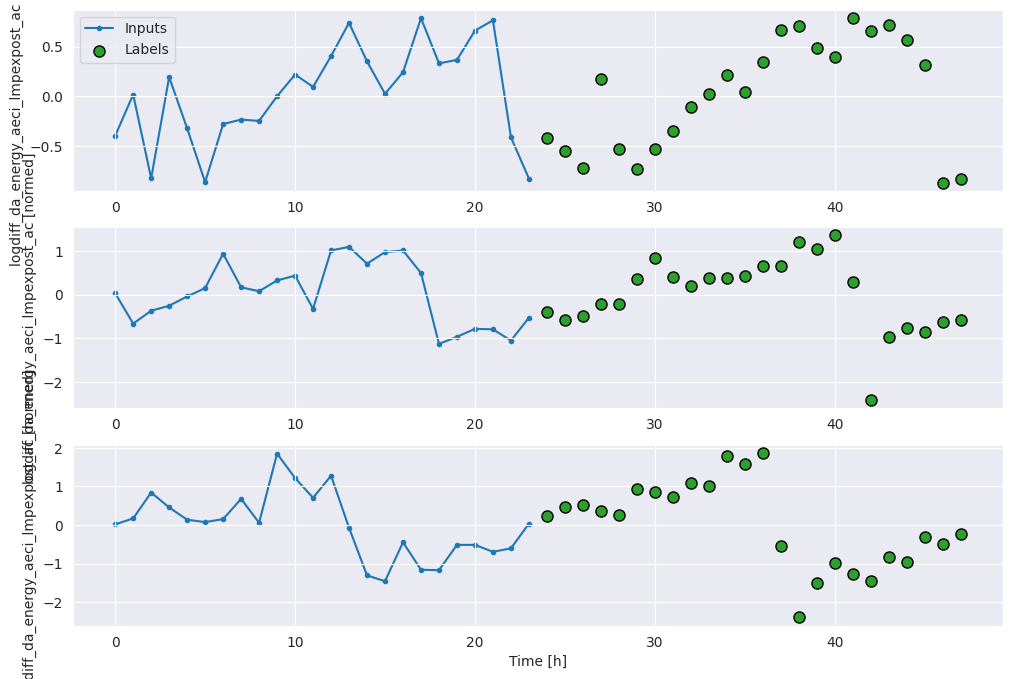

In [61]:
w1.example = example_inputs, example_labels
w1.plot(plot_col='logdiff_'+target)

Create a data set from windows

In [62]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      seed = 1,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [63]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


The Dataset.element_spec property tells you the structure, data types, and shapes of the dataset elements.

In [64]:
w1.train.element_spec

(TensorSpec(shape=(None, 24, 45), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [65]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')



Inputs shape (batch, time, features): (32, 24, 45)
Labels shape (batch, time, features): (32, 24, 1)


2023-07-29 11:26:42.849500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [13949]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:26:42.849713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


## One-lag Single Step Model

In [66]:
# configure data for single-step prediction with only one lag feature
input_width = 1
label_width = 1
shift = 1
single_step_window = WindowGenerator(
    input_width=input_width, 
    label_width=label_width, 
    shift=shift,
    label_columns=['logdiff_'+target])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['logdiff_da_energy_aeci_lmpexpost_ac']

In [67]:
# data shape
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 45)
Labels shape (batch, time, features): (32, 1, 1)


2023-07-29 11:26:43.410471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:26:43.410688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]


### Baseline Model

We just one the previous current value as the prediction for the next step

In [68]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [69]:
baseline = Baseline(label_index=column_indices['logdiff_'+target])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


55/55 [==============================] - 0s 751us/step - loss: 1.3627 - mean_absolute_error: 0.7726


2023-07-29 11:26:43.812284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-29 11:26:43.812480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-29 11:26:43.930659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1749]
	 [[{{node Placeholder/_8}}]]
2

Create a wider WindowGenerator that generates windows 24 hours of consecutive inputs and labels at a time. The new wide_window variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the time axis acts like the batch axis: each prediction is made independently with no interaction between time steps:

In [70]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=shift,
    label_columns=['logdiff_'+target])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 45)
Output shape: (32, 24, 1)


2023-07-29 11:26:44.082225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-29 11:26:44.082419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [13972]
	 [[{{node Placeholder/_8}}]]


This expanded window can be passed directly to the same baseline model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

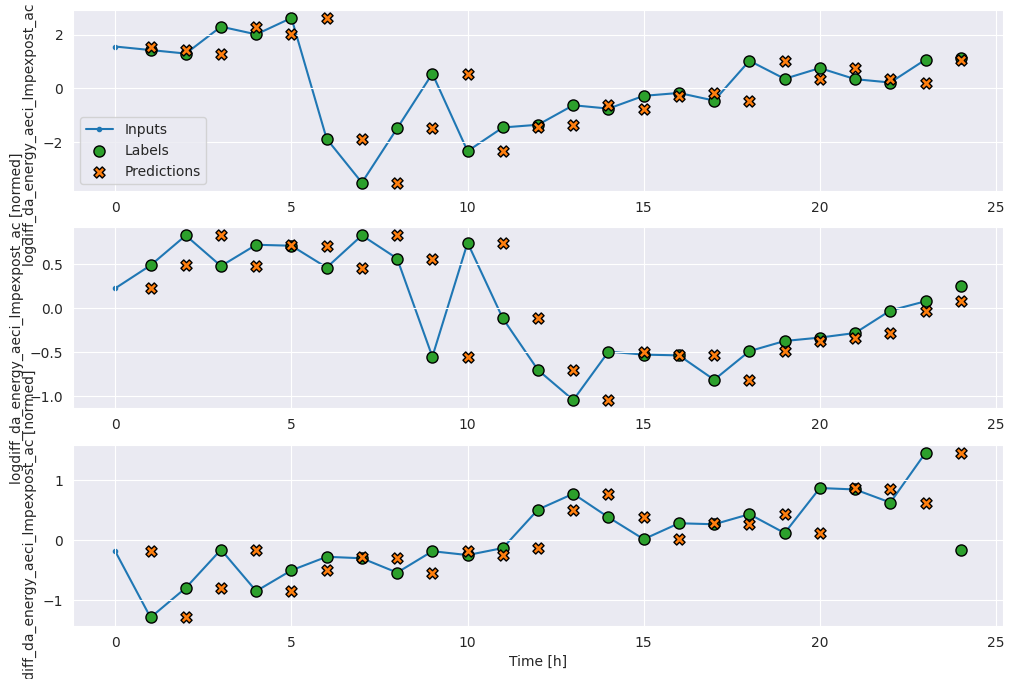

In [71]:
wide_window.plot(baseline, plot_col='logdiff_'+target)


### Linear Regression with One Lag
This uses t0 to predict t1 through a linear model, just for a comparison against the baseline model.


In [72]:
def compile_and_fit(model, window, MAX_EPOCHS=50, patience=2):
  #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
  #                                                  patience=patience,
  #                                                  mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      #callbacks=[early_stopping]
                      )
  return history

In [73]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
performance['linear'] = linear.evaluate(single_step_window.test)


Epoch 1/50


2023-07-29 11:26:44.777708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-29 11:26:44.777943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]


438/438 [==============================] - 1s 1ms/step - loss: 1.6388 - mean_absolute_error: 0.9044 - val_loss: 1.3448 - val_mean_absolute_error: 0.8204
Epoch 2/50
 44/438 [==>...........................] - ETA: 0s - loss: 1.4107 - mean_absolute_error: 0.7154

2023-07-29 11:26:45.457172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:26:45.457550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


438/438 [==============================] - 1s 3ms/step - loss: 0.9426 - mean_absolute_error: 0.6188 - val_loss: 1.0261 - val_mean_absolute_error: 0.6781
Epoch 3/50
438/438 [==============================] - 2s 4ms/step - loss: 0.8309 - mean_absolute_error: 0.5553 - val_loss: 0.9637 - val_mean_absolute_error: 0.6512
Epoch 4/50
438/438 [==============================] - 1s 2ms/step - loss: 0.8063 - mean_absolute_error: 0.5384 - val_loss: 0.9468 - val_mean_absolute_error: 0.6442
Epoch 5/50
438/438 [==============================] - 1s 2ms/step - loss: 0.7989 - mean_absolute_error: 0.5328 - val_loss: 0.9439 - val_mean_absolute_error: 0.6433
Epoch 6/50
438/438 [==============================] - 1s 1ms/step - loss: 0.7969 - mean_absolute_error: 0.5307 - val_loss: 0.9395 - val_mean_absolute_error: 0.6405
Epoch 7/50
438/438 [==============================] - 1s 3ms/step - loss: 0.7954 - mean_absolute_error: 0.5300 - val_loss: 0.9416 - val_mean_absolute_error: 0.6425
Epoch 8/50
438/438 [=======

2023-07-29 11:27:26.720947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:27:26.721150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-29 11:27:26.831410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node

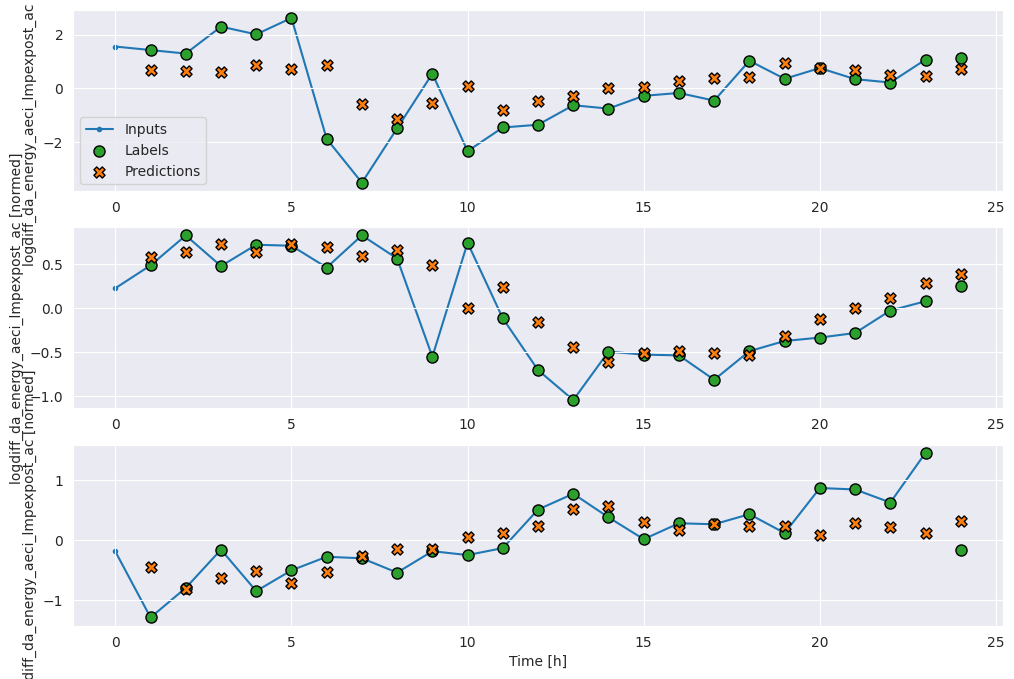

In [74]:
wide_window.plot(linear, plot_col='logdiff_'+target)

### MLP

just a neural network model with 3 hidden layers

In [75]:
mlp = tf.keras.Sequential([
    #tf.keras.layers.Flatten(input_shape=(input_width, num_features)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

#mlp.summary()

In [76]:
history = compile_and_fit(mlp, single_step_window)

val_performance['MLP'] = mlp.evaluate(single_step_window.val)
performance['MLP'] = mlp.evaluate(single_step_window.test, verbose=0)

Epoch 1/50


2023-07-29 11:27:27.451197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [13995]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:27:27.451397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]


436/438 [============================>.] - ETA: 0s - loss: 0.8179 - mean_absolute_error: 0.5528

2023-07-29 11:27:30.790546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-29 11:27:30.791583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node Placeholder/_0}}]]


438/438 [==============================] - 4s 7ms/step - loss: 0.8173 - mean_absolute_error: 0.5525 - val_loss: 0.8974 - val_mean_absolute_error: 0.6093
Epoch 2/50
438/438 [==============================] - 3s 6ms/step - loss: 0.7364 - mean_absolute_error: 0.5078 - val_loss: 0.9029 - val_mean_absolute_error: 0.6179
Epoch 3/50
438/438 [==============================] - 3s 7ms/step - loss: 0.6984 - mean_absolute_error: 0.4916 - val_loss: 0.8632 - val_mean_absolute_error: 0.5983
Epoch 4/50
438/438 [==============================] - 3s 7ms/step - loss: 0.6775 - mean_absolute_error: 0.4809 - val_loss: 0.8676 - val_mean_absolute_error: 0.5990
Epoch 5/50
438/438 [==============================] - 2s 4ms/step - loss: 0.6425 - mean_absolute_error: 0.4675 - val_loss: 0.8500 - val_mean_absolute_error: 0.5919
Epoch 6/50
438/438 [==============================] - 3s 6ms/step - loss: 0.6160 - mean_absolute_error: 0.4574 - val_loss: 0.8233 - val_mean_absolute_error: 0.5830
Epoch 7/50
438/438 [=======

2023-07-29 11:30:03.418128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:30:03.418317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1749]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:30:03.559407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Pla

Input shape: (32, 24, 45)
Output shape: (32, 24, 1)


2023-07-29 11:30:03.679999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:30:03.680203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


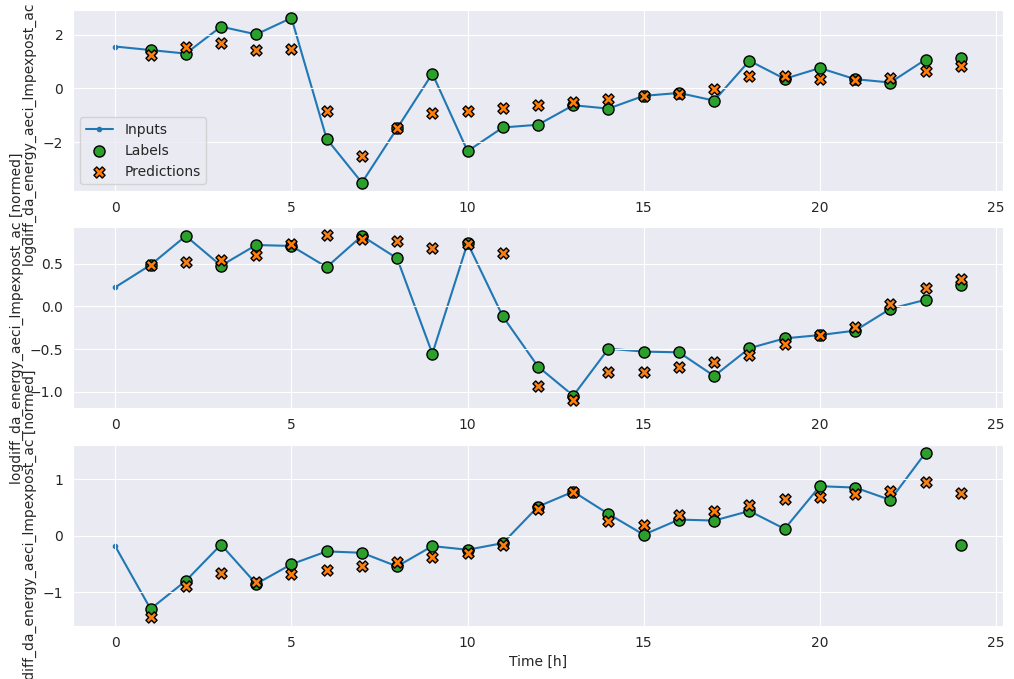

In [77]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['logdiff_'+target])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', mlp(wide_window.example[0]).shape)
wide_window.plot(mlp, plot_col='logdiff_'+target)

### RNN


In [78]:
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])

# check model summary
input_shape=(32, input_width, num_features)
lstm.build(input_shape)
lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (32, 1, 32)               9984      
                                                                 
 dropout_6 (Dropout)         (32, 1, 32)               0         
                                                                 
 dense_22 (Dense)            (32, 1, 1)                33        
                                                                 
Total params: 10,017
Trainable params: 10,017
Non-trainable params: 0
_________________________________________________________________


2023-07-29 11:30:04.103609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-29 11:30:04.104098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-29 11:30:04.104692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [79]:
history = compile_and_fit(lstm, single_step_window)

val_performance['LSTM'] = lstm.evaluate(single_step_window.val)
performance['LSTM'] = lstm.evaluate(single_step_window.test, verbose=0)


Epoch 1/50


2023-07-29 11:30:04.263251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:30:04.263430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:30:04.344439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split

434/438 [============================>.] - ETA: 0s - loss: 0.8279 - mean_absolute_error: 0.5482

2023-07-29 11:30:07.999885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-29 11:30:08.000396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-29 11:30:08.085431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node grad

438/438 [==============================] - 4s 7ms/step - loss: 0.8266 - mean_absolute_error: 0.5478 - val_loss: 0.8941 - val_mean_absolute_error: 0.6081
Epoch 2/50
438/438 [==============================] - 3s 6ms/step - loss: 0.7470 - mean_absolute_error: 0.5126 - val_loss: 0.8670 - val_mean_absolute_error: 0.5958
Epoch 3/50
438/438 [==============================] - 3s 7ms/step - loss: 0.7283 - mean_absolute_error: 0.5033 - val_loss: 0.8565 - val_mean_absolute_error: 0.5921
Epoch 4/50
438/438 [==============================] - 3s 6ms/step - loss: 0.7076 - mean_absolute_error: 0.4944 - val_loss: 0.8390 - val_mean_absolute_error: 0.5827
Epoch 5/50
438/438 [==============================] - 3s 7ms/step - loss: 0.6866 - mean_absolute_error: 0.4865 - val_loss: 0.8267 - val_mean_absolute_error: 0.5793
Epoch 6/50
438/438 [==============================] - 3s 7ms/step - loss: 0.6768 - mean_absolute_error: 0.4846 - val_loss: 0.8217 - val_mean_absolute_error: 0.5781
Epoch 7/50
438/438 [=======

2023-07-29 11:32:36.805054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1749]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:32:36.805241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:32:36.997371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1749

2023-07-29 11:32:37.148639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-29 11:32:37.149562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-29 11:32:37.150047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

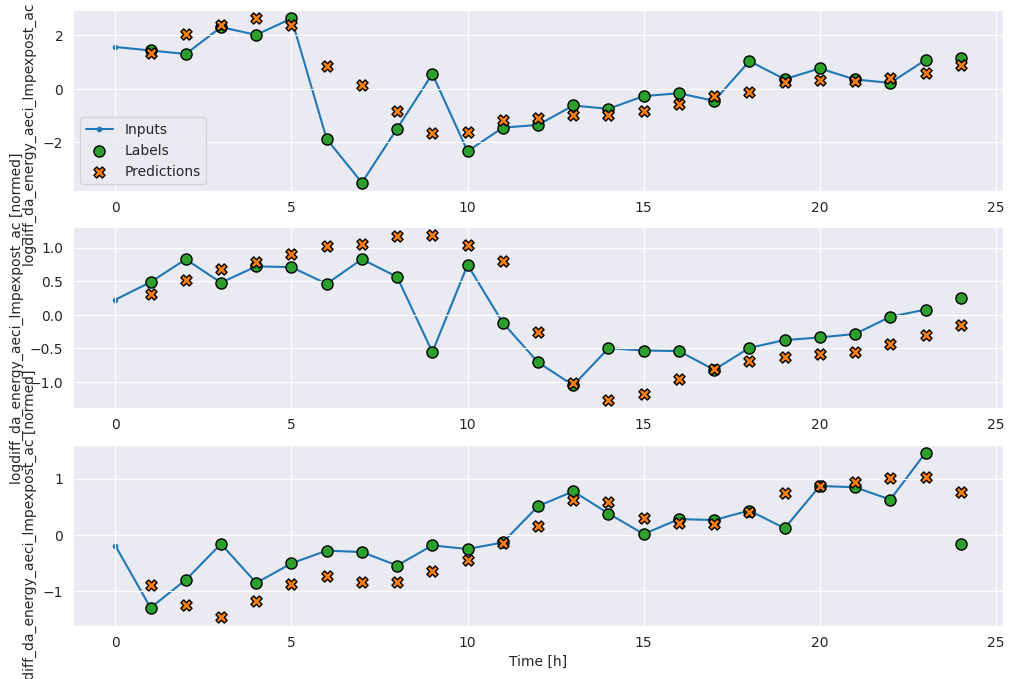

In [80]:
wide_window.plot(lstm, plot_col='logdiff_'+target)

## Multi-lag Single-output Model

Here we consider models with multiple lags and a single output.

In [81]:
input_width = 4
conv_window = WindowGenerator(
    input_width=input_width, 
    label_width=1, 
    shift=1,
    label_columns=['logdiff_' + target]
)
conv_window

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['logdiff_da_energy_aeci_lmpexpost_ac']

2023-07-29 11:32:38.078862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-29 11:32:38.079073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


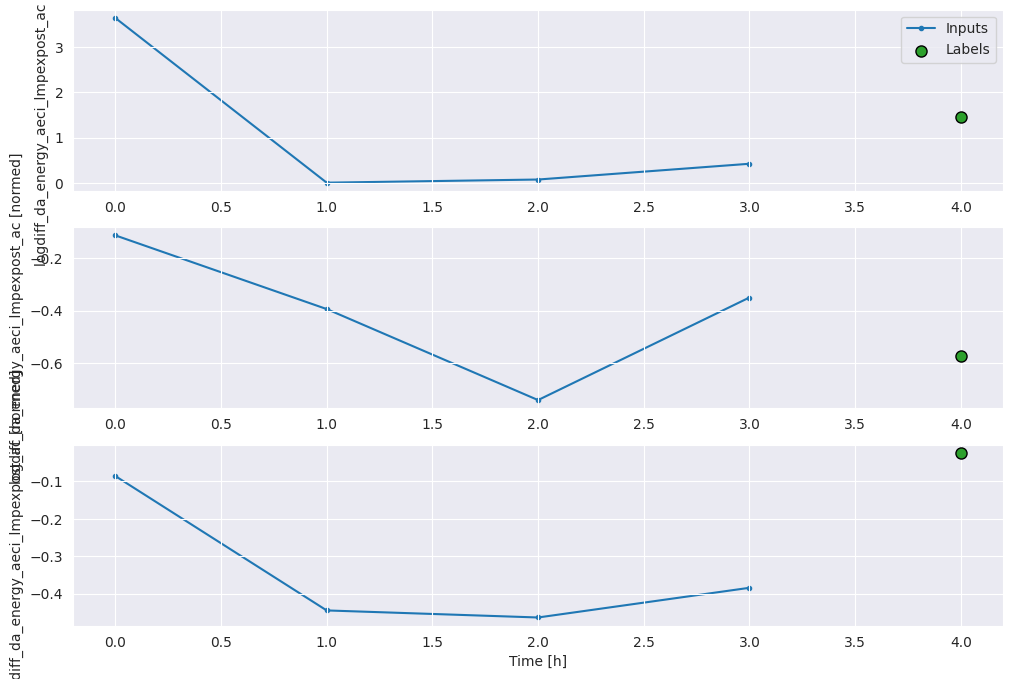

In [82]:
conv_window.plot(plot_col='logdiff_'+target)

### MLP

Let's do a dense nerual network

In [83]:
mlp_lags = tf.keras.Sequential([
    # shape: (time, features) -> time*features
    tf.keras.layers.Flatten(input_shape=(input_width, num_features)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
    # add back the time dimension
    # shape: outputs -> (1, outputs)
    tf.keras.layers.Reshape([1,-1])
])

mlp_lags.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 180)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               23168     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
 reshape_1 (Reshape)         (None, 1, 1)            

In [84]:
history = compile_and_fit(mlp_lags, conv_window)

val_performance['mlp_lags'] = mlp_lags.evaluate(conv_window.val)
performance['mlp_lags'] = mlp_lags.evaluate(conv_window.test, verbose=0)


Epoch 1/50


2023-07-29 11:32:38.900688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [13992]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:32:38.900873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]


438/438 [==============================] - 2s 3ms/step - loss: 0.8188 - mean_absolute_error: 0.5520 - val_loss: 0.8864 - val_mean_absolute_error: 0.6044
Epoch 2/50
  1/438 [..............................] - ETA: 9s - loss: 0.2731 - mean_absolute_error: 0.4154

2023-07-29 11:32:40.650070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1746]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:32:40.650299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


438/438 [==============================] - 1s 3ms/step - loss: 0.7296 - mean_absolute_error: 0.5040 - val_loss: 0.8796 - val_mean_absolute_error: 0.6100
Epoch 3/50
438/438 [==============================] - 2s 5ms/step - loss: 0.6735 - mean_absolute_error: 0.4835 - val_loss: 0.8415 - val_mean_absolute_error: 0.5917
Epoch 4/50
438/438 [==============================] - 1s 3ms/step - loss: 0.6480 - mean_absolute_error: 0.4732 - val_loss: 0.8266 - val_mean_absolute_error: 0.5809
Epoch 5/50
438/438 [==============================] - 2s 4ms/step - loss: 0.6172 - mean_absolute_error: 0.4583 - val_loss: 0.8033 - val_mean_absolute_error: 0.5745
Epoch 6/50
438/438 [==============================] - 2s 4ms/step - loss: 0.5907 - mean_absolute_error: 0.4484 - val_loss: 0.8072 - val_mean_absolute_error: 0.5796
Epoch 7/50
438/438 [==============================] - 2s 5ms/step - loss: 0.5698 - mean_absolute_error: 0.4437 - val_loss: 0.8107 - val_mean_absolute_error: 0.5808
Epoch 8/50
438/438 [=======

2023-07-29 11:34:32.643068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-29 11:34:32.643267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1746]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:34:32.782598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2

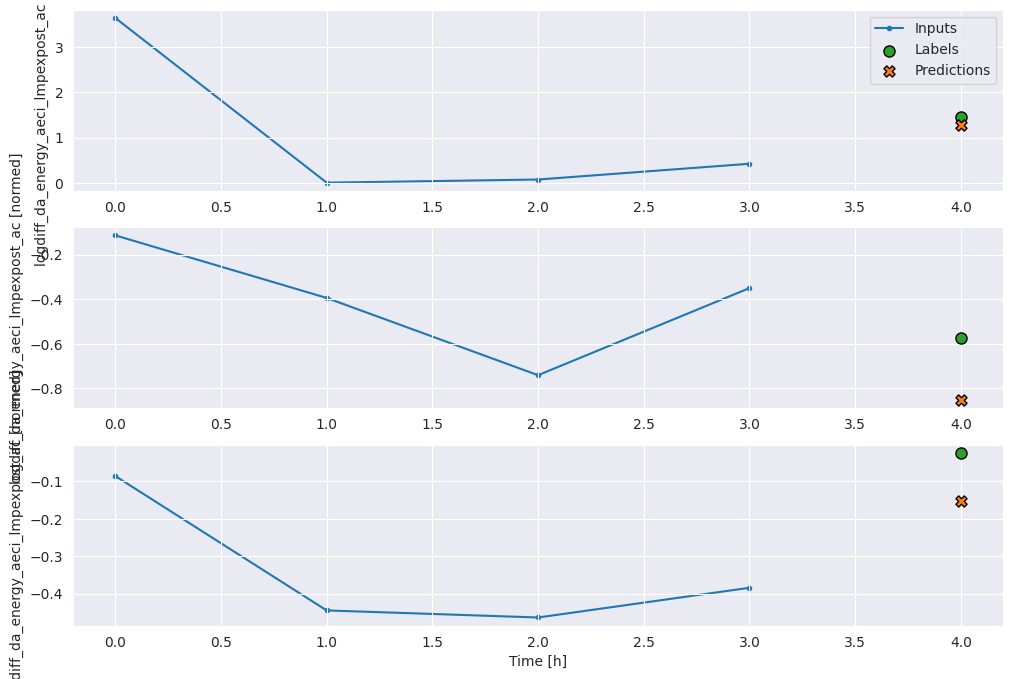

In [85]:
conv_window.plot(mlp_lags, plot_col='logdiff_'+target)

### CNN-1D

We can consider the data in the shape (1, time, features) as an image with time as the height and features as the channel. We can then use a convolutional neural network to learn the features of the data.

For Conv1D, the shape of operations are as follows:
- input: (batch_size, time, features)
- filter: (kernel_size, features, filters)
- output: (batch_size, time, filters)


We cannot use Conv2D directly because it expects a 4D input. We can reshape the data to (batch_size, time, features, 1) and use Conv2D. The shape of operations are as follows:
- input: (batch_size, time, features, 1)
- filter: (kernel_size, kernel_size, filters)

In [86]:
# this model is the same as the previous MLP model but rewritten with Conv1D layers
conv1d = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, 
                           kernel_size=(input_width,), 
                           strides=1, 
                           padding='valid', 
                           activation='relu'),
                           #input_shape=(input_width, num_features)), # this layer output shape is (batch_size, 1, 128)
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

# check model summary
# we check the model structure by given input_shape
# we dont specify the input_shape in the first layer because we want to use the model for both training and inference
# note Dense layer is applied to the last dimension of the input tensor
# if we change the input_width=27, with the given filter size, 
# the output of conv1d layer will be (batch_size, 24, 128), 
# which in the end leads to an output shape of (batch_size, 24, 1)
input_shape=(32, input_width, num_features)
conv1d.build(input_shape)
conv1d.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv1d_1 (Conv1D)           (32, 1, 128)              23168     
                                                                 
 dense_27 (Dense)            (32, 1, 64)               8256      
                                                                 
 dense_28 (Dense)            (32, 1, 64)               4160      
                                                                 
 dropout_8 (Dropout)         (32, 1, 64)               0         
                                                                 
 dense_29 (Dense)            (32, 1, 32)               2080      
                                                                 
 dense_30 (Dense)            (32, 1, 1)                33        
                                                                 
Total params: 37,697
Trainable params: 37,697
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = compile_and_fit(conv1d, conv_window, MAX_EPOCHS=50)

val_performance['Conv1d'] = conv1d.evaluate(conv_window.val)
performance['Conv1d'] = conv1d.evaluate(conv_window.test, verbose=0)


Epoch 1/20


2023-07-29 11:34:33.541871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:34:33.542087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]


438/438 [==============================] - 4s 8ms/step - loss: 0.7875 - mean_absolute_error: 0.5298 - val_loss: 0.8701 - val_mean_absolute_error: 0.6032
Epoch 2/20


2023-07-29 11:34:37.874901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1746]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:34:37.875095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


438/438 [==============================] - 4s 9ms/step - loss: 0.6785 - mean_absolute_error: 0.4840 - val_loss: 0.8475 - val_mean_absolute_error: 0.5945
Epoch 3/20
438/438 [==============================] - 4s 8ms/step - loss: 0.6301 - mean_absolute_error: 0.4661 - val_loss: 0.8264 - val_mean_absolute_error: 0.5879
Epoch 4/20
438/438 [==============================] - 3s 7ms/step - loss: 0.5975 - mean_absolute_error: 0.4500 - val_loss: 0.8135 - val_mean_absolute_error: 0.5799
Epoch 5/20
438/438 [==============================] - 3s 8ms/step - loss: 0.5780 - mean_absolute_error: 0.4427 - val_loss: 0.8262 - val_mean_absolute_error: 0.5829
Epoch 6/20
438/438 [==============================] - 4s 8ms/step - loss: 0.5694 - mean_absolute_error: 0.4408 - val_loss: 0.8173 - val_mean_absolute_error: 0.5886
Epoch 7/20
438/438 [==============================] - 4s 8ms/step - loss: 0.5350 - mean_absolute_error: 0.4272 - val_loss: 0.8081 - val_mean_absolute_error: 0.5810
Epoch 8/20
438/438 [=======

2023-07-29 11:35:40.707416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1746]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:35:40.707600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1746]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:35:40.910991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45

The output is shorter than the input.
To make the plotting work, we need make the output and input the same length.
Here we create a wide window with a few extra input time steps.

In [88]:
# plot 24-hour window
LABEL_WIDTH = 24
# to get 24 predictions, we need (24 + lags) inputs
INPUT_WIDTH = LABEL_WIDTH + (input_width - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['logdiff_'+target])

wide_conv_window


Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
Label indices: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): ['logdiff_da_energy_aeci_lmpexpost_ac']

2023-07-29 11:35:41.286445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:35:41.286655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [13969]
	 [[{{node Placeholder/_8}}]]


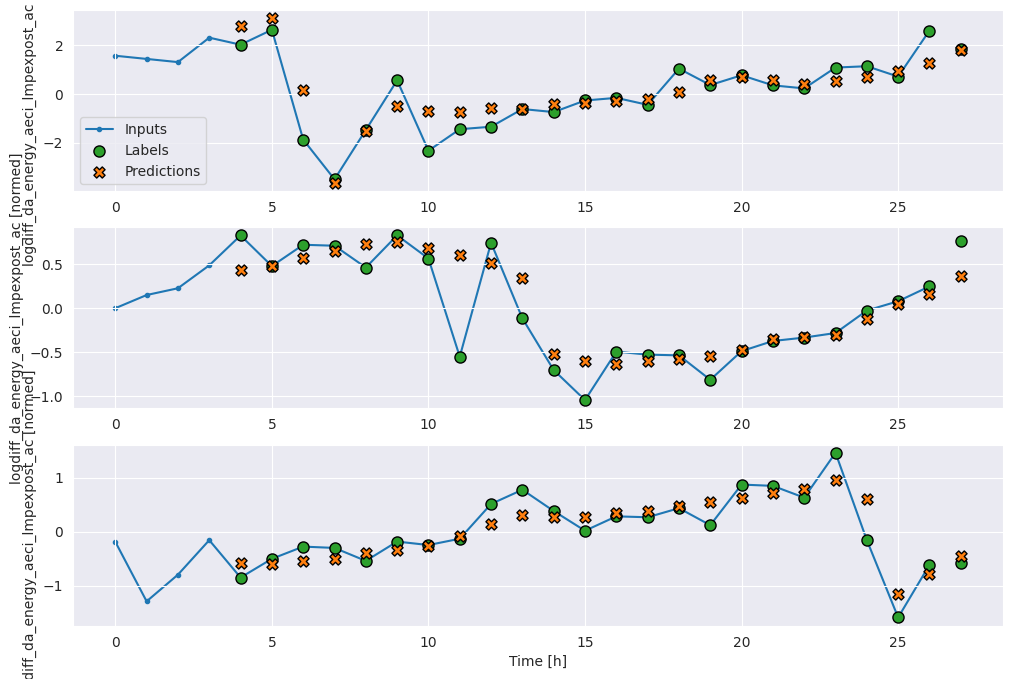

In [89]:
# Now we can make 24 independent predictions for the future 24 hours using its previous 4-step data
wide_conv_window.plot(conv1d, plot_col='logdiff_'+target)

### CNN-2D

In [114]:
conv2d = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=3, 
                           padding='valid',
                           input_shape=(8, 45, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=64,
                          kernel_size=3,
                          padding='valid'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear'),
])

input_shape = (32, 24, 45, 1)
#conv2d.build(input_shape)
#conv2d.summary()

In [115]:
input_width = 8
conv2d_window = WindowGenerator(
    input_width=input_width, 
    label_width=1, 
    shift=1,
    label_columns=['logdiff_' + target]
)

history = compile_and_fit(conv2d, conv2d_window, MAX_EPOCHS=20)

val_performance['Conv2d'] = conv2d.evaluate(conv2d_window.val)
performance['Conv2d'] = conv2d.evaluate(conv2d_window.test, verbose=0)

Epoch 1/20


2023-07-29 12:10:31.528394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [13996,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 12:10:31.528600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


438/438 [==============================] - 4s 8ms/step - loss: 0.8641 - mean_absolute_error: 0.5706 - val_loss: 0.9639 - val_mean_absolute_error: 0.6362
Epoch 2/20
  1/438 [..............................] - ETA: 12s - loss: 0.5269 - mean_absolute_error: 0.5002

2023-07-29 12:10:35.722414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-07-29 12:10:35.723064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node Placeholder/_0}}]]


438/438 [==============================] - 2s 5ms/step - loss: 0.7436 - mean_absolute_error: 0.5159 - val_loss: 0.9101 - val_mean_absolute_error: 0.6094
Epoch 3/20
438/438 [==============================] - 3s 8ms/step - loss: 0.6853 - mean_absolute_error: 0.4923 - val_loss: 0.8700 - val_mean_absolute_error: 0.6035
Epoch 4/20
438/438 [==============================] - 4s 8ms/step - loss: 0.6480 - mean_absolute_error: 0.4756 - val_loss: 0.8361 - val_mean_absolute_error: 0.5905
Epoch 5/20
438/438 [==============================] - 3s 7ms/step - loss: 0.6219 - mean_absolute_error: 0.4667 - val_loss: 0.8830 - val_mean_absolute_error: 0.6112
Epoch 6/20
438/438 [==============================] - 3s 8ms/step - loss: 0.6057 - mean_absolute_error: 0.4618 - val_loss: 0.8791 - val_mean_absolute_error: 0.6061
Epoch 7/20
438/438 [==============================] - 3s 8ms/step - loss: 0.5871 - mean_absolute_error: 0.4550 - val_loss: 0.8883 - val_mean_absolute_error: 0.6125
Epoch 8/20
438/438 [=======

2023-07-29 12:11:28.530883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-29 12:11:28.531208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 12:11:28.685787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node

### Recurrent Neural Network

In [92]:
lstm_lags = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1),
])

# check model summary
input_shape=(32, input_width, num_features)
lstm_lags.build(input_shape)
lstm_lags.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (32, 32)                  9984      
                                                                 
 dropout_9 (Dropout)         (32, 32)                  0         
                                                                 
 dense_33 (Dense)            (32, 1)                   33        
                                                                 
Total params: 10,017
Trainable params: 10,017
Non-trainable params: 0
_________________________________________________________________


2023-07-29 11:36:32.299887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-29 11:36:32.300460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-29 11:36:32.300967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [93]:
history = compile_and_fit(lstm_lags, conv_window, MAX_EPOCHS=20)

val_performance['LSTM_lags'] = lstm_lags.evaluate(conv_window.val)
performance['LSTM_lags'] = lstm_lags.evaluate(conv_window.test, verbose=0)


Epoch 1/20


2023-07-29 11:36:32.382699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-29 11:36:32.382882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]
2023-07-29 11:36:32.462324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node grad

435/438 [============================>.] - ETA: 0s - loss: 0.8497 - mean_absolute_error: 0.5642

2023-07-29 11:36:36.110106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1746]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:36:36.110674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1746]
	 [[{{node Placeholder/_8}}]]
2023-07-29 11:36:36.192205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' wi

438/438 [==============================] - 4s 7ms/step - loss: 0.8473 - mean_absolute_error: 0.5635 - val_loss: 0.9058 - val_mean_absolute_error: 0.6099
Epoch 2/20
438/438 [==============================] - 3s 7ms/step - loss: 0.7449 - mean_absolute_error: 0.5176 - val_loss: 0.8497 - val_mean_absolute_error: 0.5878
Epoch 3/20
438/438 [==============================] - 3s 7ms/step - loss: 0.6925 - mean_absolute_error: 0.4945 - val_loss: 0.8147 - val_mean_absolute_error: 0.5748
Epoch 4/20
438/438 [==============================] - 3s 7ms/step - loss: 0.6477 - mean_absolute_error: 0.4796 - val_loss: 0.7884 - val_mean_absolute_error: 0.5670
Epoch 5/20
438/438 [==============================] - 3s 7ms/step - loss: 0.6238 - mean_absolute_error: 0.4679 - val_loss: 0.7750 - val_mean_absolute_error: 0.5614
Epoch 6/20
438/438 [==============================] - 3s 7ms/step - loss: 0.5959 - mean_absolute_error: 0.4586 - val_loss: 0.7616 - val_mean_absolute_error: 0.5589
Epoch 7/20
438/438 [=======

2023-07-29 11:37:32.443555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:37:32.443736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


55/55 [==============================] - 0s 3ms/step - loss: 0.7128 - mean_absolute_error: 0.5427


2023-07-29 11:37:32.696635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [1750,45]
	 [[{{node Placeholder/_0}}]]
2023-07-29 11:37:32.696816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


The above plotting function cannot be directly used here, similarly to the MLP case.

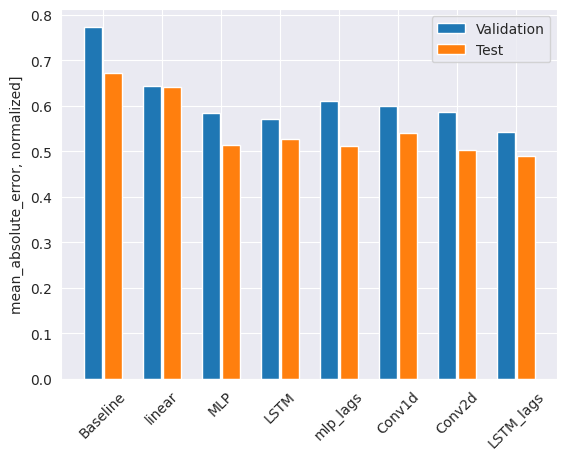

In [116]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_lags.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
